### Imports iniciais

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold


### Pré-Processamento


In [40]:
df = pd.read_csv("akc-data-latest.csv")

In [41]:

df.rename(columns={"Unnamed: 0": "breeds"}, inplace=True)


In [42]:
#entendendo o formato das colunas do dataframe e a natureza dos elementos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   breeds                       277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

In [45]:
#dropando colunas não numéricas, exceto a coluna popularidade

object_cols = df.select_dtypes(include=['object']).columns
object_cols = object_cols.drop(["popularity","trainability_category"])

df = df.drop(columns=object_cols)



In [46]:
final_test = df[
    df['popularity'].isna()
].drop(
    'popularity', axis=1
).dropna()

final_test


,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,trainability_category,demeanor_value
5,50.800,63.500,27.215542,45.359237,10.0,12.0,0.2,0.6,0.8,0.6,Agreeable,0.6
10,53.340,68.580,20.411657,31.751466,12.0,15.0,0.4,0.6,0.8,1.0,Eager to Please,0.6
14,48.260,55.880,21.772434,31.751466,12.0,15.0,0.4,0.8,1.0,0.2,May be Stubborn,0.4
18,43.180,50.800,14.514956,20.411657,12.0,15.0,0.4,0.4,0.8,0.8,Easy Training,0.6
23,31.750,39.370,12.246994,15.875733,12.0,12.0,0.4,0.6,0.6,0.2,May be Stubborn,1.0
25,43.180,52.070,16.782918,29.937096,12.0,15.0,0.4,0.8,0.6,0.6,Agreeable,0.4
30,55.880,66.040,24.947580,29.483504,10.0,12.0,0.4,0.8,0.8,0.8,Easy Training,0.4
44,49.022,55.118,16.782918,27.215542,12.0,15.0,0.2,0.4,0.6,0.8,Easy Training,0.6
45,25.400,30.480,2.494758,4.082331,12.0,14.0,0.6,0.2,0.4,0.6,Agreeable,0.8
53,53.340,68.580,24.947580,40.823313,10.0,14.0,0.2,0.4,0.8,0.8,Easy Training,0.6


In [48]:
df.drop(columns="trainability_value")

,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_category,demeanor_value
0,148,22.86,29.21,3.175147,4.535924,12.0,15.0,0.6,0.6,0.6,Easy Training,1.0
1,113,63.50,68.58,22.679619,27.215542,12.0,15.0,0.8,0.2,0.8,May be Stubborn,0.2
2,60,58.42,58.42,22.679619,31.751466,11.0,14.0,0.6,0.4,0.6,Eager to Please,0.8
3,47,60.96,71.12,31.751466,58.967008,10.0,13.0,0.8,0.6,0.8,Eager to Please,0.6
4,58,58.42,63.50,34.019428,38.555351,10.0,14.0,0.6,0.6,0.8,Independent,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
272,167,54.61,63.50,20.411657,29.483504,12.0,14.0,0.2,0.6,0.8,Agreeable,0.6
273,NaN,48.26,63.50,12.700586,27.215542,12.0,15.0,0.2,0.6,0.8,Independent,0.6
274,140,25.40,58.42,4.535924,24.947580,13.0,18.0,0.2,0.2,0.8,Agreeable,0.6
275,NaN,53.34,58.42,18.143695,24.947580,10.0,12.0,0.4,0.6,0.8,May be Stubborn,0.4


In [49]:
df.isna().sum()


popularity                  79
min_height                   0
max_height                   0
min_weight                   2
max_weight                   2
min_expectancy               3
max_expectancy               3
grooming_frequency_value     7
shedding_value              20
energy_level_value           6
trainability_value          24
trainability_category       24
demeanor_value              25
dtype: int64

In [50]:
#dropando eleementos NaN do dataframe, como parte do pré-processamento

fit_df = df

In [51]:
df.columns

Index(['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight',
       'min_expectancy', 'max_expectancy', 'grooming_frequency_value',
       'shedding_value', 'energy_level_value', 'trainability_value',
       'trainability_category', 'demeanor_value'],
      dtype='object')

### Agregação de colunas

In [52]:
df['average_height'] = df[['min_height', 'max_height']].mean(axis=1)
df['average_weight'] = df[['min_weight', 'max_weight']].mean(axis=1)
df['average_expectancy'] = df[['min_expectancy', 'max_expectancy']].mean(axis=1)

# Drop the original min/max columns
df.drop(columns=['min_height', 'max_height', 'min_weight', 'max_weight', 
                 'min_expectancy', 'max_expectancy'], inplace=True)


In [53]:
#Transformando elementos da coluna popularidade em numéricos
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')


In [54]:
df["trainability_category"].value_counts()

KeyError: 'breeds'

<Axes: >

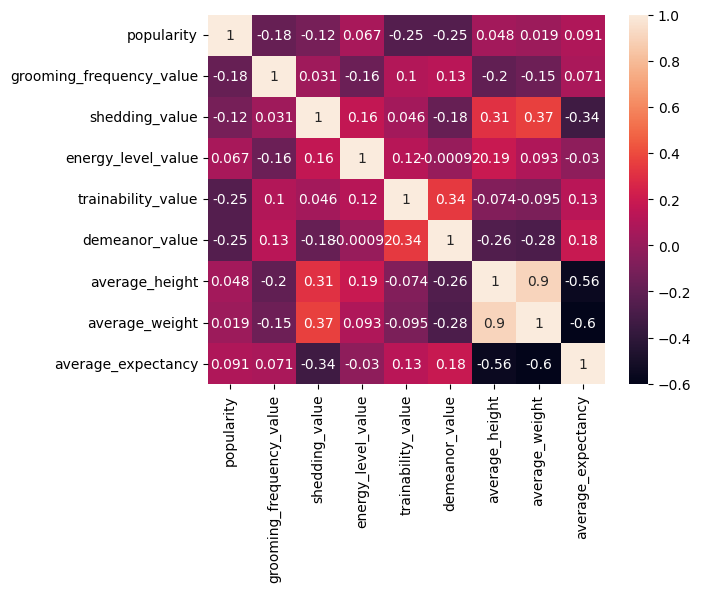

In [57]:
correlacao = df.drop("trainability_category", axis=1).corr(method='spearman')
sns.heatmap(correlacao, annot=True)

### Divisão entre treino e teste

In [61]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.name != 'trainability_category' else x, axis=0)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("trainability_category", axis=1), df["trainability_category"], test_size=0.25, random_state=42)


## Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

# Predict Output
predicted = model.predict(X_test)


ValueError: Input contains NaN

In [17]:
predicted == y_test

30     False
126    False
220    False
142    False
255    False
       ...  
192    False
242    False
67     False
132    False
154    False
Name: breeds, Length: 70, dtype: bool

In [18]:
predicted

array(['Drentsche Patrijshond', 'Berger Picard', 'Gordon Setter',
       'Norwich Terrier', 'Norfolk Terrier', 'Pudelpointer',
       'Drentsche Patrijshond', 'Bernese Mountain Dog', 'Kromfohrlander',
       'Treeing Tennessee Brindle', 'Finnish Spitz',
       'Caucasian Shepherd Dog', 'Havanese', 'Brittany', 'Plott Hound',
       'Labrador Retriever', 'American Water Spaniel', 'Airedale Terrier',
       'Deutscher Wachtelhund', 'English Cocker Spaniel',
       'Lancashire Heeler', 'Belgian Malinois', 'Chow Chow',
       'Cocker Spaniel', 'Bedlington Terrier', 'Berger Picard',
       'Swedish Lapphund', 'Belgian Sheepdog',
       'Manchester Terrier (Standard)', 'Irish Setter', 'Rat Terrier',
       'Nederlandse Kooikerhondje', 'Cocker Spaniel', 'Cairn Terrier',
       'Papillon', 'Russell Terrier', 'Norwich Terrier', 'Berger Picard',
       'Pharaoh Hound', 'Bracco Italiano', 'Brittany',
       'American Water Spaniel', 'Cairn Terrier', 'Hokkaido',
       'Dogue de Bordeaux', 'Weimara

### Avaliação de resultados

In [19]:
((predicted == y_test).sum())/len(y_test) * 100

0.0

In [20]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted, average="weighted")

0.0

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

### Avaliação de resultados

In [23]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)



Accuracy: 0.0


In [24]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted, average="weighted")

0.0

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Visualização da Árvore Binária

In [26]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH